In [1]:
from pathlib import Path
import polars as pl
import polars.selectors as cs
import json
from pprint import pprint

pl.Config(tbl_cols=20, tbl_rows=20, tbl_width_chars=180)

In [5]:
def get_data(weighting):
    allo_path = Path(f"/home/ross/coding/pi_3/modular_trader/continuous/records/{weighting}_allocations.json")
    
    with open(allo_path, 'r') as allo_file:
        allo = json.load(allo_file)
        print(f"{weighting} length: {len(allo)}")
    return pl.from_dicts(allo)

def load_allos(df_in):
    return (
        df_in.with_columns(pl.col('timestamp').mul(1000000).cast(pl.Int64).cast(pl.Datetime(time_zone='UTC')).alias('timestamp'))
        .sort('timestamp')
        .group_by_dynamic("timestamp", every="1h").agg(cs.ends_with('USDT').mean())
        .upsample(time_column='timestamp', every='1h').fill_null(strategy='forward')
    )

def load_returns(pair, start):
    datapath = Path(f"/home/ross/coding/pi_3/modular_trader/bin_ohlc_5m/{pair}.parquet")
    df = (
        pl.scan_parquet(datapath)
        .set_sorted('timestamp')
        .select(['timestamp', 'close'])
        .filter(pl.col('timestamp') >= start)
        .group_by_dynamic(pl.col('timestamp'), every='1h')
        .agg(pl.last('close'))
        .sort('timestamp')
        .with_columns(pl.col('close').pct_change().shift(-1).fill_null(0).alias(f'{pair}_returns'))
        .drop('close')
        .collect()
    )

    return df

def insert_rtns(df):
    df_start = df.item(0, 'timestamp')
    for pair in df.columns:
        if pair == 'timestamp':
            continue
        df = df.with_columns(load_returns(pair, df_start))
    
    return df

def calc_pnl(df, pairs, leverage):
    for pair in pairs:
        df = df.with_columns(
            pl.col(f"{pair}_returns").mul(pl.col(pair)).mul(leverage).alias(f'{pair}_pnl')
        )
        
    return df

def get_dataset(weighting, leverage):
    data = get_data(weighting)
    data = load_allos(data)
    pairs = [p for p in data.columns if p != 'timestamp']
    data = insert_rtns(data)
    data = calc_pnl(data, pairs, leverage)
    
    pnls =  data.select(cs.contains('pnl'))
    pnls = pnls.with_columns(pnls.sum_horizontal().alias('sum'))
    pnls = pnls.with_columns(pl.col('sum').add(1).cum_prod().alias('cum_prod'))
    pnls = pnls.with_columns(data['BTCUSDT_returns'].alias('bitcoin'))
    pnls = pnls.with_columns(pl.col('bitcoin').add(1).cum_prod())
    
    # if i ever use the timestamps i will need to fix that here, because i am just putting 1.0 in every column including timestamp
    row = pnls.to_dicts()[0]
    row = pl.DataFrame({k: 1.0 for k in row.keys()})
    
    pnls = pl.concat([row, pnls])
    
    return pnls

In [6]:
lev = 3
flat = get_dataset('flat', lev)
lin = get_dataset('lin', lev)
perf = get_dataset('perf', lev)

flat length: 82
lin length: 82
perf length: 82


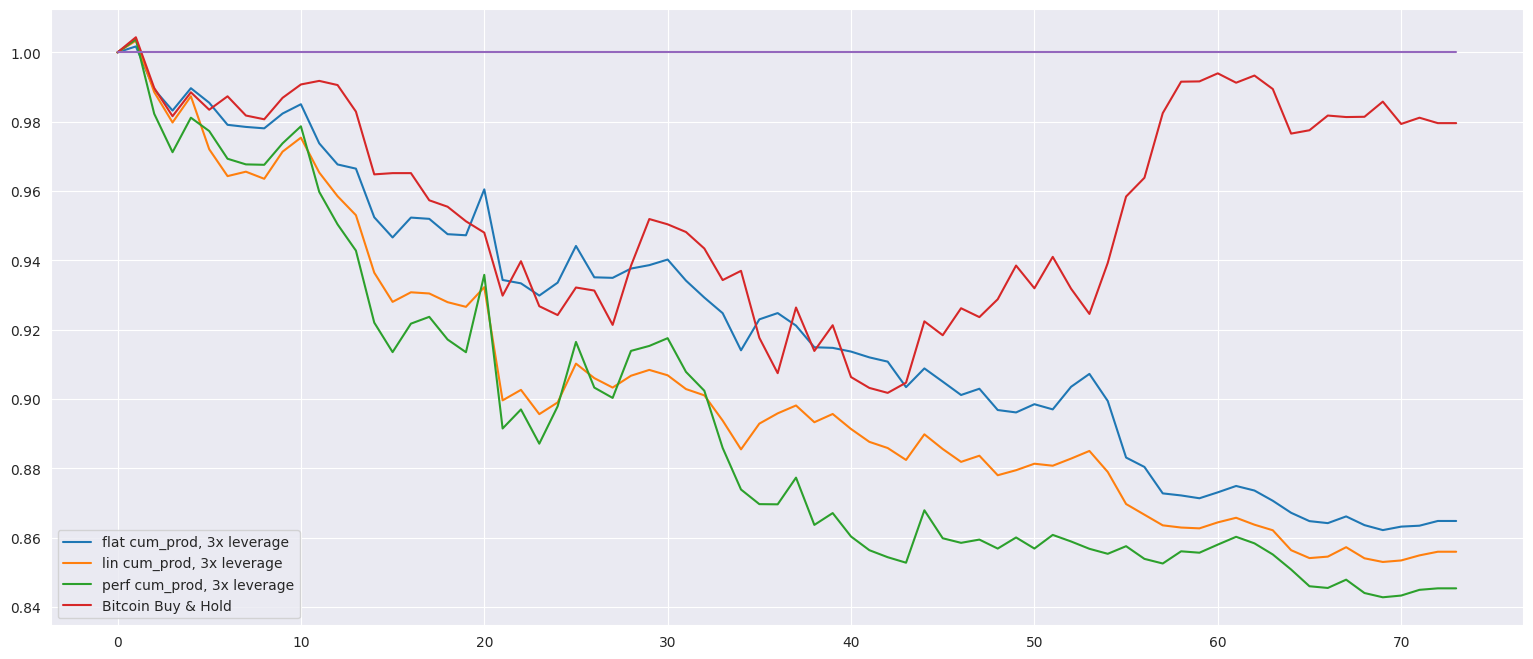

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(19, 8))
# t = f"{' '.join(my_pairs)} pnl" if len(my_pairs) <= 10 else f"{len(my_pairs)} pairs pnl"
sns.lineplot(data=flat['cum_prod'], label=f'flat cum_prod, {lev}x leverage')
sns.lineplot(data=lin['cum_prod'], label=f'lin cum_prod, {lev}x leverage')
sns.lineplot(data=perf['cum_prod'], label=f'perf cum_prod, {lev}x leverage')
sns.lineplot(data=lin['bitcoin'], label=f'Bitcoin Buy & Hold')
sns.lineplot(data=[1] * len(lin))
plt.show()

In [15]:
avg_cum = pl.DataFrame([flat['cum_prod'], lin['cum_prod'], perf['cum_prod']], schema=['flat', 'lin', 'perf']).mean_horizontal()

In [16]:
cum_diffs = pl.DataFrame([flat['cum_prod'], lin['cum_prod'], perf['cum_prod']], schema=['flat', 'lin', 'perf'])
cum_diffs = cum_diffs.with_columns(
    pl.col('flat').sub(avg_cum).alias('flat'),
    pl.col('lin').sub(avg_cum).alias('lin'),
    pl.col('perf').sub(avg_cum).alias('perf'),
)
cum_diffs

flat,lin,perf
f64,f64,f64
0.0,0.0,0.0
-0.001231,0.000428,0.000803
0.002618,0.001823,-0.004441
0.005152,0.001707,-0.006859
0.003609,0.001288,-0.004898
0.007199,-0.006222,-0.000977
0.008195,-0.006601,-0.001593
0.007906,-0.005007,-0.002899
0.008357,-0.006197,-0.00216


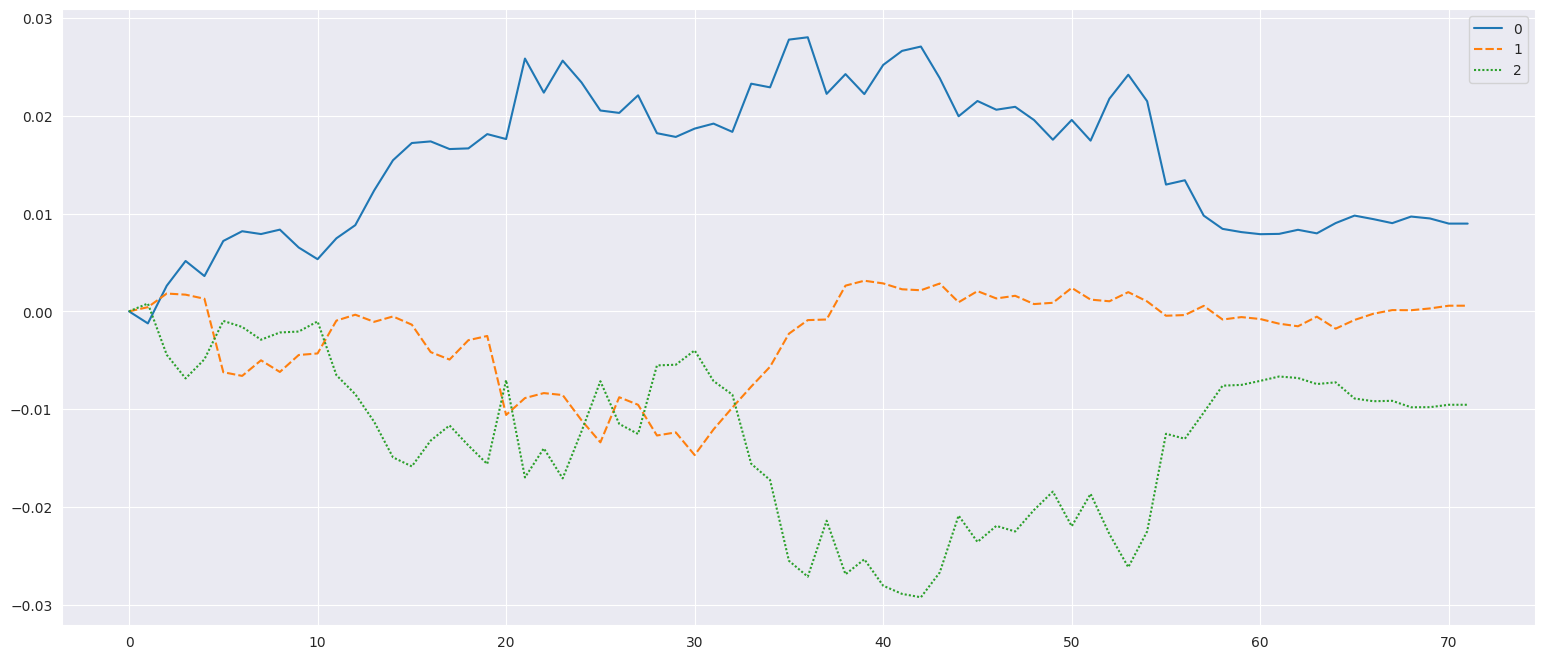

In [17]:
plt.figure(figsize=(19, 8))
sns.lineplot(data=cum_diffs)
plt.legend()
plt.show()

In [9]:
from binance import Client
import binance.exceptions as bx
import binance.enums as be
import mt.resources.keys as keys

client = Client(keys.bPkey, keys.bSkey, testnet=False)
pair = 'BTCUSDT'
size = 20
buy_order = client.create_margin_order(symbol=pair, side=be.SIDE_BUY, type=be.ORDER_TYPE_MARKET, quoteOrderQty=size)

BinanceAPIException: APIError(code=-2010): Account has insufficient balance for requested action.

In [120]:
buy_order

{'symbol': 'BTCUSDT',
 'orderId': 25433294103,
 'clientOrderId': 'gNpIwLivrsz61ij5t7KNiE',
 'transactTime': 1709804799651,
 'price': '0',
 'origQty': '0.00029',
 'executedQty': '0.00029',
 'cummulativeQuoteQty': '19.3723654',
 'status': 'FILLED',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'side': 'BUY',
 'fills': [{'price': '66801.26',
   'qty': '0.00029',
   'commission': '0.00003357',
   'commissionAsset': 'BNB',
   'tradeId': 3464339449}],
 'isIsolated': False,
 'selfTradePreventionMode': 'EXPIRE_MAKER'}

In [129]:
details = client.get_margin_loan_details(asset='USDT', txId='158712634589')

In [130]:
details

{'total': 1,
 'rows': [{'timestamp': 1709899224331,
   'txId': 158712634589,
   'asset': 'USDT',
   'principal': '25.89002',
   'status': 'CONFIRMED',
   'clientTag': ''}]}

In [142]:
repay = client.repay_margin_loan(asset='USDT', amount='1.25')

In [143]:
repay

{'tranId': 158804708713, 'clientTag': ''}

In [149]:
details = client.get_margin_repay_details(asset='USDT', txId=158804708713)

In [150]:
details

{'total': 1,
 'rows': [{'timestamp': 1709917846899,
   'txId': 158804708713,
   'asset': 'USDT',
   'amount': '1.25',
   'principal': '1.25',
   'interest': '0',
   'status': 'CONFIRMED',
   'clientTag': ''}]}

In [242]:
client.get_margin_order(symbol='OCEANUSDT', orderId=1020266938)

{'symbol': 'OCEANUSDT',
 'orderId': 1020266938,
 'clientOrderId': 'SSPt6WnrgFGg2cLcXsRcis',
 'price': '0',
 'origQty': '43',
 'executedQty': '43',
 'cummulativeQuoteQty': '50.7056',
 'status': 'FILLED',
 'timeInForce': 'GTC',
 'type': 'MARKET',
 'side': 'BUY',
 'stopPrice': '0',
 'icebergQty': '0',
 'time': 1710284434585,
 'updateTime': 1710284434585,
 'isWorking': True,
 'accountId': 10622325,
 'isIsolated': False,
 'selfTradePreventionMode': 'EXPIRE_MAKER'}